***todo 2023-2-6***
1. 3 seconds로 train, test 잘 나누기 (같은 노래 안겹치게 하기)
2. XGboost 추가
3. Deep N은 다른 notebook에 추가하자.
4. translate to english

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

import librosa, librosa.display
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (10, 3)

# Classification with given features

## Data

In [2]:
features_30_sec = pd.read_csv('data/GTZAN_data/features_30_sec.csv')
features_3_sec = pd.read_csv('data/GTZAN_data/features_3_sec.csv')

data = features_30_sec

In [3]:
X = data.iloc[:,2:-1]
labels = data.iloc[:,-1]
cat_y = pd.Categorical(labels)
y = pd.Series(cat_y.codes)

In [4]:
X

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,1.222421e+06,...,1.789867,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665
996,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,1.046621e+06,...,3.739020,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624
997,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,8.042154e+05,...,1.838090,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515
998,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,1.332712e+06,...,-2.812176,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088


In [5]:
scaler = StandardScaler()

# train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=123)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [6]:
y_train.value_counts()

4    78
5    78
6    74
0    73
1    72
7    68
8    67
2    66
3    62
9    62
dtype: int64

In [7]:
y_test.value_counts()

3    38
9    38
2    34
8    33
7    32
1    28
0    27
6    26
5    22
4    22
dtype: int64

## Model

In [8]:
svc = SVC(kernel='rbf')
rf = RandomForestClassifier()
# clf = AdaBoostClassifier()
# clf = GradientBoostingClassifier()

**Hyperparameter tuning**

In [9]:
param_grid1 = {'C': [1, 10, 100], 
              'gamma': [0.1, 0.01, 0.001]} 
cv = StratifiedKFold(n_splits=3, shuffle=True)  
grid1 = GridSearchCV(svc, param_grid1, cv=cv, verbose = 1)
grid1.fit(X_train_scaled, y_train)
grid1.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


SVC(C=10, gamma=0.01)

In [10]:
param_grid2 = {'n_estimators': [50, 100],
               'max_depth': [None, 3, 6]}
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid2 = GridSearchCV(rf, param_grid2, cv=cv, verbose = 1)
grid2.fit(X_train, y_train)
grid2.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


RandomForestClassifier()

**train**

In [11]:
clf1 = grid1.best_estimator_
clf1.fit(X_train_scaled, y_train)

clf2 = grid2.best_estimator_
clf2.fit(X_train, y_train)

RandomForestClassifier()

**predict**

In [12]:
# for SVC
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [13]:
y_true = y_test.copy()
y_pred1 = clf1.predict(X_test_scaled) # SVC
y_pred2 = clf2.predict(X_test)

## Results

SVM Accuracy:  0.7166666666666667
SVM F1:  0.7291989900441196


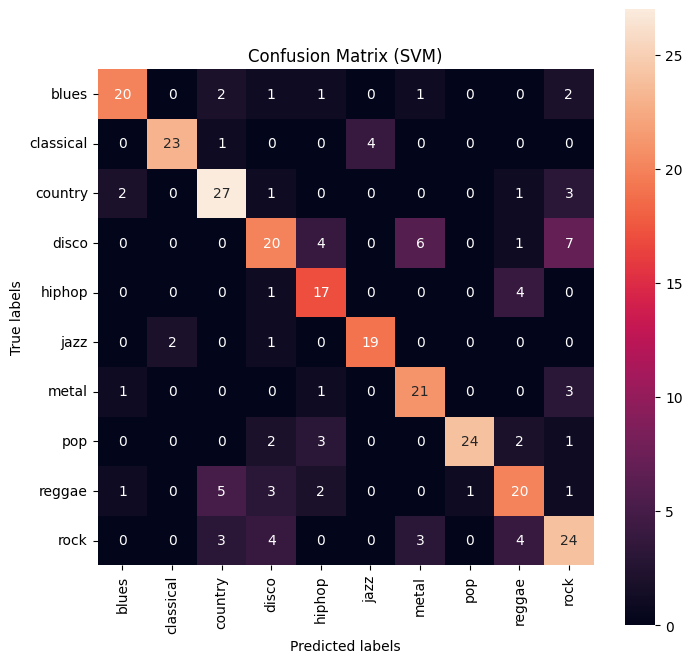

In [14]:
print('SVM Accuracy: ', accuracy_score(y_true, y_pred1))
print('SVM F1: ', f1_score(y_true, y_pred1, average='macro'))

f,ax= plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_true, y_pred1), annot=True, square=True, 
            xticklabels=cat_y.categories, yticklabels=cat_y.categories, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (SVM)')
plt.show()

In [15]:
print("SVC classification report:",'\n')
print(classification_report(y_true, y_pred1))
print(dict(zip(cat_y.categories, range(10))))

SVC classification report: 

              precision    recall  f1-score   support

           0       0.83      0.74      0.78        27
           1       0.92      0.82      0.87        28
           2       0.71      0.79      0.75        34
           3       0.61      0.53      0.56        38
           4       0.61      0.77      0.68        22
           5       0.83      0.86      0.84        22
           6       0.68      0.81      0.74        26
           7       0.96      0.75      0.84        32
           8       0.62      0.61      0.62        33
           9       0.59      0.63      0.61        38

    accuracy                           0.72       300
   macro avg       0.74      0.73      0.73       300
weighted avg       0.73      0.72      0.72       300

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


RF Accuracy:  0.6866666666666666
RF F1:  0.6897627104864169


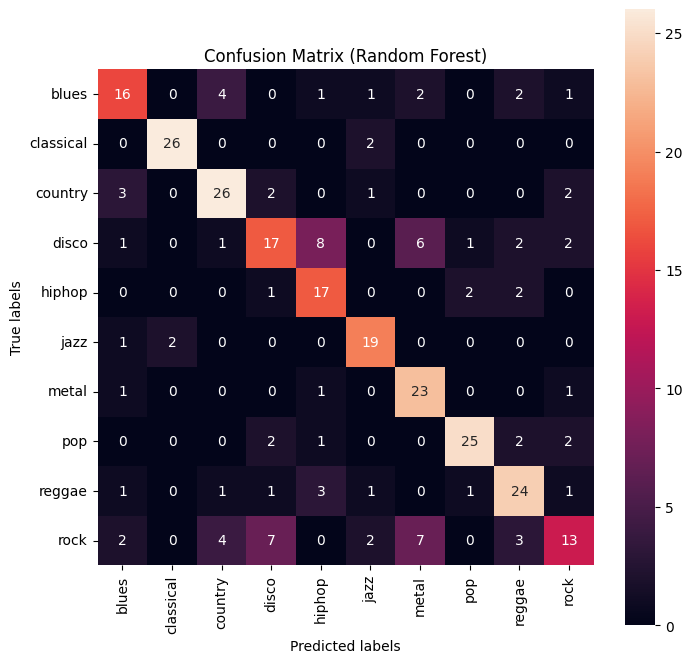

In [16]:
print('RF Accuracy: ', accuracy_score(y_true, y_pred2))
print('RF F1: ', f1_score(y_true, y_pred2, average='macro'))

f,ax= plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_true, y_pred2), annot=True, square=True, 
            xticklabels=cat_y.categories, yticklabels=cat_y.categories, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (Random Forest)')
plt.show()

In [17]:
print("RF classification report:",'\n')
print(classification_report(y_true, y_pred2))
print(dict(zip(cat_y.categories, range(10))))

RF classification report: 

              precision    recall  f1-score   support

           0       0.64      0.59      0.62        27
           1       0.93      0.93      0.93        28
           2       0.72      0.76      0.74        34
           3       0.57      0.45      0.50        38
           4       0.55      0.77      0.64        22
           5       0.73      0.86      0.79        22
           6       0.61      0.88      0.72        26
           7       0.86      0.78      0.82        32
           8       0.69      0.73      0.71        33
           9       0.59      0.34      0.43        38

    accuracy                           0.69       300
   macro avg       0.69      0.71      0.69       300
weighted avg       0.69      0.69      0.68       300

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


## interpretation

- 30초의 각 노래에 대해 장르를 타겟으로 하여 분류기의 성능을 확인한 결과, 정확도 및 F1스코어가 70% 정도가 되는 것을 볼 수 있다. 대부분 잘 분류하지만 안되는 경우도 있다. 경우 별로 이를 확인해보자.

- 우선 각 장르마다 잘못 분류한 경우 어떤 장르로 오분류했는지를 보자. (RF 기준)
    - **블루스**: 컨트리 4 등
    - **클래식**(점수 높은 편): 재즈 2 
    - **컨트리**: 블루스 3, 디스코 3 등
    - **디스코**(점수 낮은 편): 힙합 7, 메탈 6 등
    - **힙합**: 레게 3 등
    - **재즈**: 클래식 2 등
    - **메탈**: 블루스 2, 록 2 등
    - **팝**: 디스코 2, 힙합 2 등
    - **레게**: 힙합 5 등
    - **록**: 디스코 9, 메탈 4 등
    
- 오분류한 장르 쌍을 보면, **블루스-컨트리, 클래식-재즈, 디스코-힙합, 힙합-레게, 메탈-록 등** 직관적으로 생각했을 때 장르적 유사성이 있는 장르 쌍들 위주이다.
- 즉, 주어진 오디오 내용 기반의 피쳐가 사람들이 인위적으로 분류해놓은 장르와 비슷하게, 어느정도 음악적 특성의 정보를 가지고 있음을 유추할 수 있다.

# 3초 데이터

- 정확도를 높이고자, 데이터를 확장하자. 
- 노래를 추가하는 대신, 각 30초 노래를 10개로 나눈 3초 단위의 오디오로 분할한다.
- 다만, 노래 A의 앞 부분을 훈련하여 노래 A의 뒷 부분을 예측하는 것은 쉽기 때문에 높은 결과에 대해 경계할 필요가 있다.
- SVC만 사용한다.

In [18]:
data = features_3_sec

In [19]:
X = data.iloc[:,2:-1]
labels = data.iloc[:,-1]
cat_y = pd.Categorical(labels)
y = pd.Series(cat_y.codes)

In [20]:
scaler = StandardScaler()
# train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=123)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [21]:
svc = SVC(kernel='rbf')
param_grid1 = {'C': [10, 100], 
              'gamma': [0.1, 0.01, 0.001]} 
cv = StratifiedKFold(n_splits=3, shuffle=True)  
grid1 = GridSearchCV(svc, param_grid1, cv=cv, verbose = 1)
grid1.fit(X_train_scaled, y_train)
print(grid1.best_estimator_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
SVC(C=100, gamma=0.01)


In [22]:
clf1 = grid1.best_estimator_
clf1.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.01)

In [23]:
# for SVC
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
y_true = y_test.copy()
y_pred1 = clf1.predict(X_test_scaled) # SVC

SVC Accuracy:  0.9062395729062396
SVC F1:  0.905678670449305


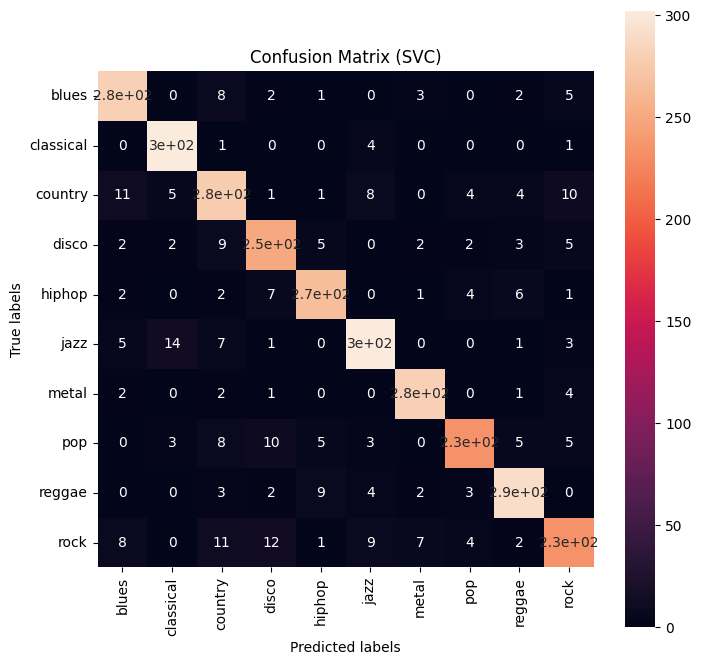

SVC classification report: 

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       301
           1       0.93      0.98      0.95       308
           2       0.84      0.86      0.85       321
           3       0.87      0.89      0.88       281
           4       0.92      0.92      0.92       289
           5       0.91      0.91      0.91       332
           6       0.95      0.97      0.96       290
           7       0.93      0.86      0.89       273
           8       0.92      0.93      0.93       314
           9       0.87      0.81      0.84       288

    accuracy                           0.91      2997
   macro avg       0.91      0.91      0.91      2997
weighted avg       0.91      0.91      0.91      2997

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [24]:
print('SVC Accuracy: ', accuracy_score(y_true, y_pred1))
print('SVC F1: ', f1_score(y_true, y_pred1, average='macro'))

f,ax= plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_true, y_pred1), annot=True, square=True, 
            xticklabels=cat_y.categories, yticklabels=cat_y.categories, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (SVC)')
plt.show()

print("SVC classification report:",'\n')
print(classification_report(y_true, y_pred1))
print(dict(zip(cat_y.categories, range(10))))

- 역시나 결과가 더 좋다. 데이터가 많아져서도 있지만, 같은 노래안의 파트를 예측하는 것이 더 쉽기 때문에 더욱 그럴 것이다.

- 오분류의 경우를 봤을 때 장르적 유사성이 여전히 보인다.
    - 블루스-컨트리, 클래식-재즈, 컨트리-록, 메탈-록, 팝-디스코, 힙합-디스코, 힙합-레게 등
    
- 반대로 실제 장르와 예측 장르의 겹침이 단 하나도 없는 장르 쌍을 보자.
    - 블루스-클래식, 힙합-클래식, 메탈-클래식, 레게-클래식, 블루스-팝, 힙합-재즈, 재즈-메탈
    - 공감이 되는가?